This notebook is used to compute Frenkel-Ladd integration using values of the average per particle lattice energy over a range of spring constant values. A nice explanation of the theory behind Frenkel-Ladd integration can be found the Methods section of [Haji-Akbari & Engel 2011](https://aip.scitation.org/doi/10.1063/1.3651370). By transforming an "imperfect" structure into the "perfect" Einstein crystal along a thermodynamically reversible path, we can calculate the difference in our structure from this ideal state. Specifically, Frenkel-Ladd integration gives a difference in free energy between the Einstein crystal and the structure in question:$$\Delta{A}=\int_{0}^{\gamma_{max}}\langle{U}\rangle_{\gamma}d\gamma=A_{Ein}-A_{struc}$$



The lattice energies and their standard deviations are calculated using Hoomd's [frenkel_ladd_energy](https://hoomd-blue.readthedocs.io/en/stable/module-hpmc-field.html#hoomd.hpmc.field.frenkel_ladd_energy) class. 

In [2]:
import signac
import hoomd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
hoomd.context.initialize("--mode=cpu")

HOOMD-blue v2.7.0 DOUBLE HPMC_MIXED MPI SSE SSE2 
Compiled: 10/09/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


In [4]:
project=signac.get_project()

This function `read_log` is just to read in the hoomd data stored in my frenkel-ladd log file `calc_FL.log`. From the log file, we get the spring constants, the average per particle energies, and the per particle standard deviations. Note that we take the log of spring constants, more on that below. All of these arrays get inverted because when in the hoomd code I scan from large to small gamma values, but we want to integrate from small to large gamma values.

In [5]:
def read_log(job):
    pipe = np.genfromtxt(job.fn('calc_FL.log'), names=True)
    return np.log(pipe['lattice_translational_spring_constant'][::-1]), pipe['lattice_energy_pp_avg'][::-1], pipe['lattice_energy_pp_sigma'][::-1]

As noted in the documentation for `frenkel_ladd_energy`, the values for the lattice energies and standard deviations logged by hoomd are automatically multiplied by the spring constant. Because of this, we really want to integrate over the natural log of the spring constants, since the subtitution will account for that extra factor of gamma. So, the `calc_FL` function takes in data from `read_log`, creates arrays for the quantities of interest, and then loops over the logged gamma values to exclude any log gamma values less than zero, as this causes odd behavor in the data (there's a better explanation of this, I'm still not sure about it myself, but basically the particle energies go go through values they shouldn't unless you exclude these negative log gamma values). Then we use `np.trapz` to estimate the area under the curve for the particle energies over the range of gamma values, which gives us the free energy difference. 

In [6]:
## per particle
def calc_FL(log_gamma, U, delU):
    avg_energies = []
    sigmas = []
    pos_gammas = []
    for i in range(0,len(log_gamma)):
        if log_gamma[i] >= 0:
            avg_energies.append(U[i]) 
            sigmas.append(delU[i])
            pos_gammas.append(log_gamma[i])
    avg_energies = np.array(avg_energies)
    sigmas = np.array(sigmas)
    pos_gammas = np.array(pos_gammas)
    return np.trapz(avg_energies, pos_gammas), np.trapz(sigmas, pos_gammas)

And finally, we loop over all of the jobs and get values for the free energy differences and the errors. The rest of the work is just plotting!

In [7]:
for job in project:
    if job.isfile(job.fn('calc_FL.log'))==True:
        data = read_log(job)
        job.document['delA'],job.document['delA_err']=calc_FL(*data) 

So my intent in doing Frenkel-Ladd calculations was to get a direct compairison between the free energies of two diamond structures, cubic and hexagonal, when those structures are are made of the same shaped particles. My data therefore sweeps over a range of particles values, namely the truncation of the tetrahedra(x axis) and packing fraction or structure density (color bar). The first plot just shows the difference in free energy from the einstein crystal for the two structures, with circles being cubic and triangles being hexagonal formations. The top of the next plot shows the difference in free energy between these cubic and hexagonal structures, with the y axis being $A_{cub}-A_{hex}$, and it shows that across all of our shape parameters cubic diamond has a slightly lower free energy (the free energies should be negative to start with), which is what we would expect(yay!). 

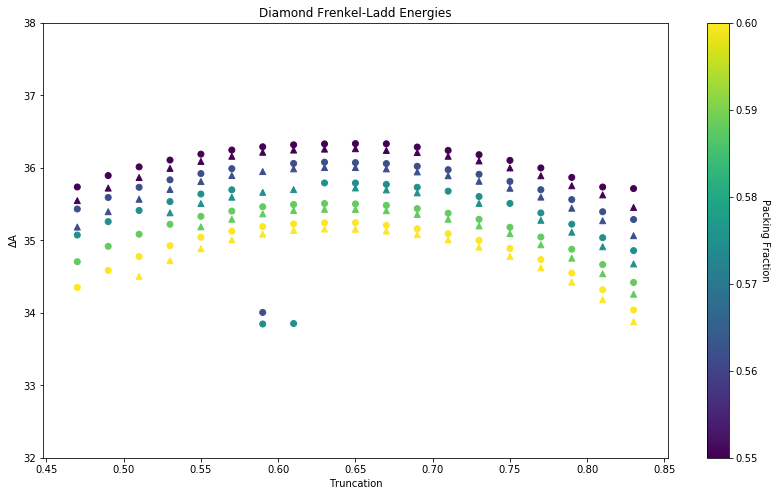

In [8]:
markers = {'hexagonaldiamond':'^', 'cubicdiamond':'o'}
fig, ax = plt.subplots(figsize=(14,8))
for key, group in project.find_jobs(doc_filter={"delA.$exists":True}).groupby(['structure', 'pf']):
    jobs = list(sorted(group, key=lambda job: job.sp.truncation))
    arr = [job.document['delA'] for job in jobs]
    x_arr = [job.sp['truncation'] for job in jobs]
    err = [job.document['delA_err'] for job in jobs]
    im = ax.scatter(x_arr, arr, c=np.ones_like(x_arr)*key[1], marker=markers[key[0]], cmap=plt.cm.viridis)
    im.set_clim(0.55, 0.6)
colorbar = fig.colorbar(im, ax=ax)
colorbar.set_label('Packing Fraction', labelpad=12, rotation=270)
plt.ylim(32,38)
plt.xlabel('Truncation')
plt.ylabel(r'$\Delta$A')
plt.title('Diamond Frenkel-Ladd Energies')
plt.show()

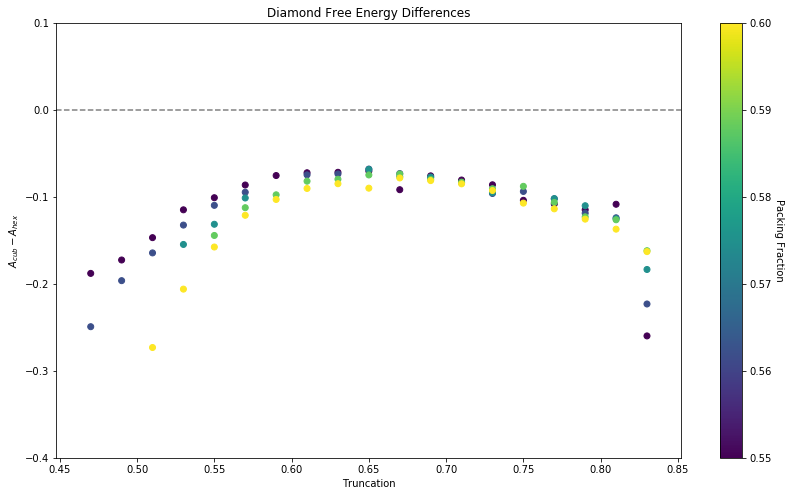

In [12]:
fig, ax = plt.subplots(figsize=(14,8))
for key, group in project.find_jobs(doc_filter={"delA.$exists":True}).groupby(['pf']):
    jobs = list(sorted(group, key=lambda job: job.sp.truncation))
    x_arr = np.unique([job.sp['truncation'] for job in jobs])
    hex_A = []
    cub_A = []
    for job in jobs:
        if job.sp['structure'] == 'hexagonaldiamond':
            hex_A.append(job.document['delA'])
        if job.sp['structure'] == 'cubicdiamond':
            cub_A.append(job.document['delA'])
    diff = np.array(hex_A) - np.array(cub_A)
    im = ax.scatter(x_arr, diff, c=np.ones_like(x_arr)*key[0], cmap=plt.cm.viridis)
    im.set_clim(0.55, 0.6)
colorbar = fig.colorbar(im, ax=ax)
colorbar.set_label('Packing Fraction', labelpad=12, rotation=270)
plt.xlabel('Truncation')
plt.ylabel(r'$A_{cub}-A_{hex}$')
plt.title('Diamond Free Energy Differences')
plt.axhline(0, ls='--', color='black', alpha=0.5)
plt.ylim(-0.4,0.1)
plt.show()